<a href="https://colab.research.google.com/github/lawalmz/AI_logistic_regration_assignment_on_cancer_data/blob/main/LogisticRegressionproject_21906776.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tasks:

    Implement polynomial features [10p]
    Implement minmax normalisation [10p]
    Implement logistic regression loss function and gradient descent algorithm [10p]
    Plot learning and test curve [10p]
    Generate test prediction (test dataset) [10p]
    Fill the confusion matrix (test dataset) [10p]
    Compute F1 score, precision, recall and accuracy using confusion matrix (test dataset) [10p]
    Try various learning rate and compute F1 score of each learning rate (test dataset) [10p]
    Learning rates: (0.0001, 0.0005, 0.0007, 0.001, 0.005, 0.001, 0.01, 0.05, 0.09, 0.1, 0.4, 0.7) [10p]
    Generate the lists for each learning rate and its associated F1 score and plot (test dataset) [10p]

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# read the data file\n",
df = pd.read_csv('/content/drive/MyDrive/cancer_data.csv')
df.head() # diplay first 5 rows

# remove some of the columns because we don't need
df.drop('Unnamed: 32', inplace = True, axis = 1)
df.drop('id', inplace=True, axis=1)

# target output is a string, replace them to be integer values
df['diagnosis'] = df['diagnosis'].map({'M':1, 'B':0})
print(df.head())

print()

# display the columns' title
columns_title=list(df.columns)
print(columns_title)

# convert to numpy
data=df.to_numpy()

np.random.shuffle(data)

# split inputs and output data
data_in=data[:,1:] #input
data_out=data[:,0] #output (m,) vector

# print first 5 rows of outputs
print(data_out[:5])

# reshape data_out to match with the predicted output
data_out = np.reshape(data_out,(-1,1)) # dimension becomes (m,1)

# delete unnecesary variables to save some memory in Colab
del data, df

# display the shape of inputs and outputs
print(f"input dim:{data_in.shape}")
print(f"output dim:{data_out.shape}")

   diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0          1        17.99         10.38          122.80     1001.0   
1          1        20.57         17.77          132.90     1326.0   
2          1        19.69         21.25          130.00     1203.0   
3          1        11.42         20.38           77.58      386.1   
4          1        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
0         0.2419  ...         25.38          

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# split data into training and test sets

ratio = 0.7 # percentage of training dataset

len_tr = int(ratio*len(data_in)) # data_in.shape[0]

# training dataset
tr_data_in = data_in[:len_tr]
tr_data_out = data_out[:len_tr]

# test dataset
test_data_in = data_in[len_tr:]
test_data_out = data_out[len_tr:]

# display the shape of inputs and outputs
print(f"number of train data: {tr_data_in.shape}")
print(f"number of test data: {test_data_in.shape}")

number of train data: (398, 30)
number of test data: (171, 30)


In [ ]:
def generate_polynomial_features(data, degree):
    num_samples, num_features = data.shape
    expanded_features = []

    for i in range(num_features):
        for j in range(i+1, num_features):
                new_feature = data[:, i] * data[:, j]
                expanded_features.append(new_feature)

    expanded_features = np.array(expanded_features).T
    return np.concatenate((data, expanded_features), axis=1)

# Specify the degree of polynomial features you want
degree = 2  # Change this to the desired degree

# Generate polynomial features for training data
tr_data_in_poly = generate_polynomial_features(tr_data_in, degree)

# Generate polynomial features for test data
test_data_in_poly = generate_polynomial_features(test_data_in, degree)

# Print the shapes to check
print(tr_data_in.shape)
print(tr_data_in_poly.shape)
print(test_data_in.shape)
print(test_data_in_poly.shape)


(398, 30)
(398, 465)
(171, 30)
(171, 465)


In [ ]:
#Normalization using min max section

# Min-Max normalization
tr_min = np.min(tr_data_in_poly, axis=0)
tr_max = np.max(tr_data_in_poly, axis=0)

tr_data_in_norm = (tr_data_in_poly - tr_min) / (tr_max - tr_min)

test_data_in_norm = (test_data_in_poly-tr_min)/(tr_max - tr_min)

# Display first 5 rows
print(tr_data_in_norm[:5])
print()

# Display number of features
print(tr_data_in_norm.shape)
print()

print(test_data_in_norm.shape)
print()




[[0.2493729  0.43050389 0.23764771 ... 0.11489307 0.11332062 0.15830318]
 [0.96734346 0.56002705 0.9889434  ... 0.40558625 0.42514038 0.10356402]
 [0.31989209 0.27730808 0.30633681 ... 0.08275185 0.09206186 0.07408087]
 [0.2072507  0.26580994 0.19832769 ... 0.15128638 0.14690293 0.13567719]
 [0.21860949 0.29252621 0.20793311 ... 0.15564683 0.14211098 0.15652326]]

(398, 465)

(171, 465)



In [ ]:
def sig(x):
    return 1 / (1 + np.exp(-x))


# Gradient descent algorithm training loop
max_epoch = 10000
tr_err = []  # store train error in each epoch
test_err = []  # store train error in each epoch
w = np.zeros((1, tr_data_in_norm.shape[1]), dtype=float)  # initial parameters
b = 0.  # initial bias term
lr = 0.1

for epoch in range(max_epoch):
    z = np.matmul(tr_data_in_norm, w.T) + b
    ypred = sig(z)

    z2 = np.matmul(test_data_in_norm, w.T) + b
    ypred_test = sig(z2)
    epsilon = 1e-10

    m = len(tr_data_in_norm)
    # below is the loss function
    loss = -(1 / m) * (np.sum(tr_data_out * np.log(ypred + epsilon) + (1 - tr_data_out) * np.log(1 - ypred + epsilon), axis=0))
    tr_err.append(loss.squeeze())

    test_loss = -1 * (np.mean(test_data_out * np.log(ypred_test + epsilon) + (1 - test_data_out) * np.log(1 - ypred_test + epsilon), axis=0))
    test_err.append(test_loss.squeeze())

    # update the weights
    w = w - lr * np.sum((ypred - tr_data_out) * tr_data_in_norm, axis=0) / m
    b = b - lr * np.sum((ypred - tr_data_out), axis=0) / m

    if (epoch % (max_epoch / 5) == 0):
        print(f"epoch {epoch}/{max_epoch}  Loss(train):{tr_err[-1]:.4f}  Loss(test):{test_err[-1]:.4f}")


epoch 0/10000  Loss(train):0.6931  Loss(test):0.6931
epoch 2000/10000  Loss(train):0.1057  Loss(test):0.0697
epoch 4000/10000  Loss(train):0.0856  Loss(test):0.0502
epoch 6000/10000  Loss(train):0.0766  Loss(test):0.0423
epoch 8000/10000  Loss(train):0.0713  Loss(test):0.0379


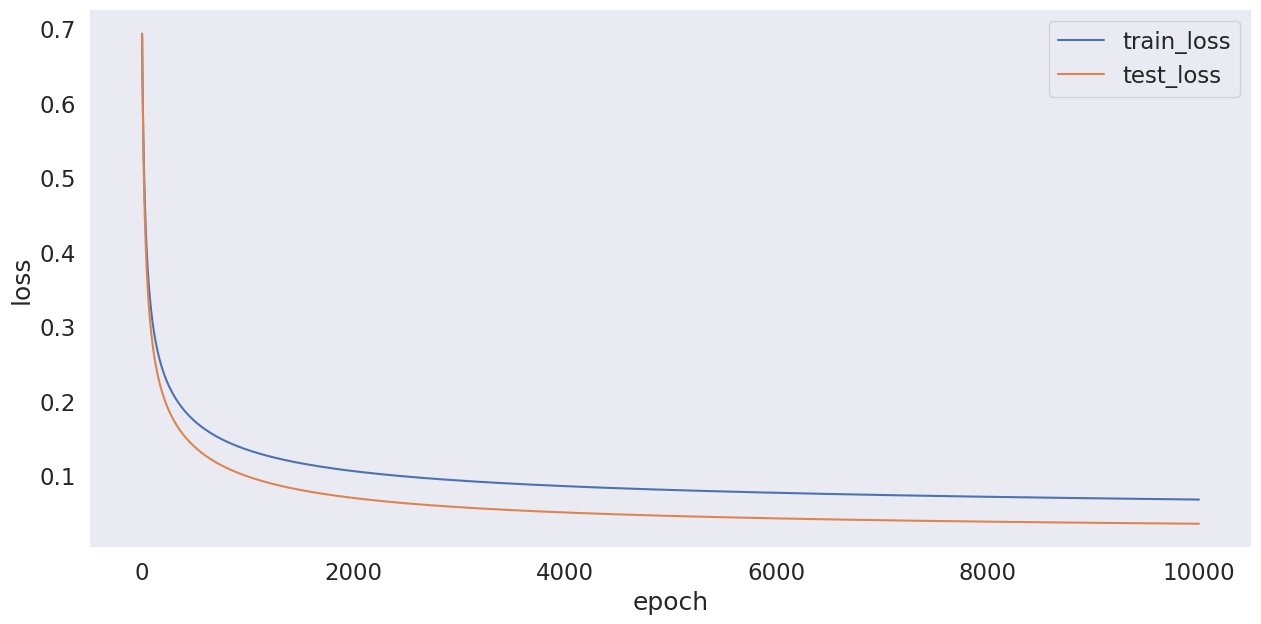

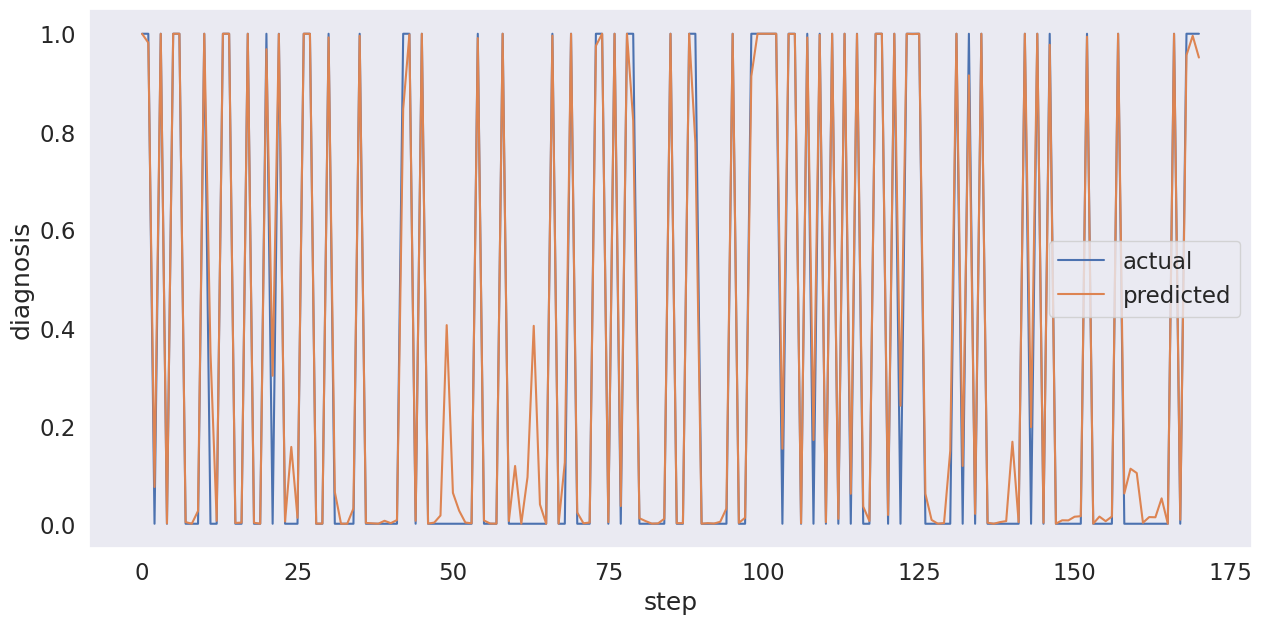

In [ ]:
# Visualizing error curve (training error and test error)
import matplotlib.pyplot as plt

plt.figure(figsize = (15,7))
plt.plot(tr_err,label="train_loss")
plt.plot(test_err,label="test_loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize = (15,7))
plt.plot(test_data_out, label="actual")
plt.plot(ypred_test, label="predicted")
plt.xlabel('step')
plt.ylabel('diagnosis')
plt.grid()
plt.legend()
plt.show()

Confusion Matrix for Test Data:
[[ 61   0]
 [  0 110]]


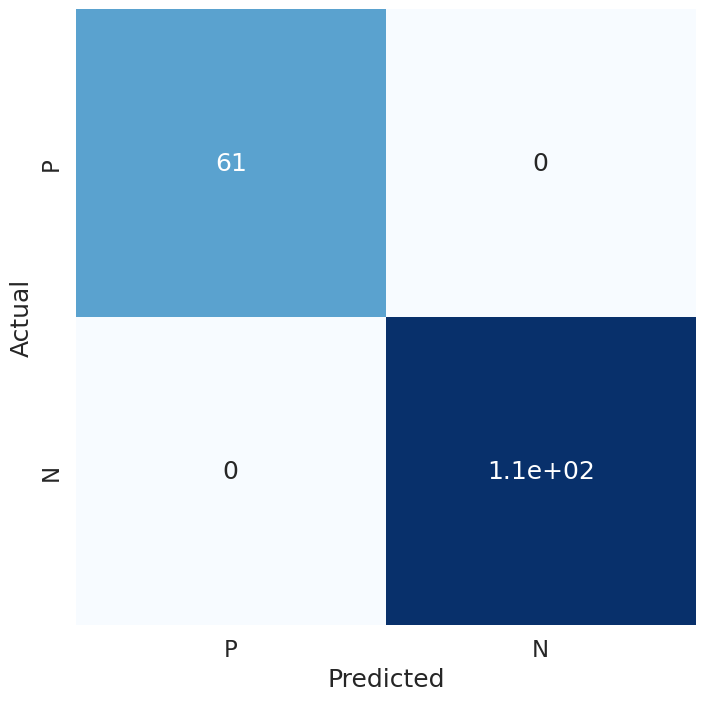

Confusion matrix shape: (2, 2)


In [ ]:
# Plot the confusion matrix using the provided helper function

# Assuming you have obtained predictions from your trained model
ypred_test = sig(np.dot(test_data_in_norm, w.T) + b)

# Threshold predictions at 0.5
predicted_labels_test = (ypred_test >= 0.5).astype(int)

# Create confusion matrix
conf_mat = np.zeros((2, 2), dtype=int)

for i in range(len(test_data_out)):
    if test_data_out[i] == 1 and predicted_labels_test[i] == 1:
        conf_mat[0, 0] += 1
    elif test_data_out[i] == 1 and predicted_labels_test[i] == 0:
        conf_mat[0, 1] += 1
    elif test_data_out[i] == 0 and predicted_labels_test[i] == 1:
        conf_mat[1, 0] += 1
    elif test_data_out[i] == 0 and predicted_labels_test[i] == 0:
        conf_mat[1, 1] += 1

# Helper function to plot confusion matrix
def plot_conf_mat(conf_mat):
    class_label = ["P", "N"]

    plt.subplots(figsize=(8, 8))
    sns.set(font_scale=1.5)  # Adjust the font to fit
    sns.heatmap(conf_mat,
                annot=True,
                cbar=False,
                xticklabels=class_label,
                yticklabels=class_label,
                cmap='Blues')

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Print the confusion matrix
print("Confusion Matrix for Test Data:")
print(conf_mat)




plot_conf_mat(conf_mat)

print(f"Confusion matrix shape: {conf_mat.shape}")


In [ ]:
#Calculating F1 score, precision, recall and accuracy using confusion matrix
#
#
# Calculate and print metrics
accuracy = (conf_mat[1, 1] + conf_mat[0, 0]) / np.sum(conf_mat)
precision = conf_mat[1, 1] / (conf_mat[1, 1] + conf_mat[0, 1])
recall = conf_mat[1, 1] / (conf_mat[1, 1] + conf_mat[1, 0])
f1_score = 2 * (precision * recall) / (precision + recall)


print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


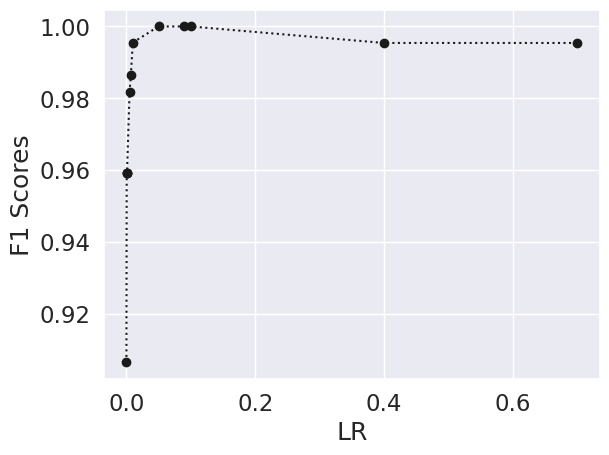

In [ ]:
# test each learning rate and obtained F1 score for each one,
# do experiments one by one and fill the F1 scores manually
# use test dataset
# The best accuracy i got is  1.0000 using 0.05,0.08,0.1 learning rate with degree 2


LR = [0.0001, 0.0005, 0.0007, 0.001, 0.005, 0.007, 0.01, 0.05, 0.09, 0.1, 0.4, 0.7]
# you need to update F1_score_list
F1_score_list = [ 0.9064,0.9593,0.9593,0.9593,0.9818,0.9864,0.9955,1.0000,1.0000,1.0000,0.9954, 0.9954]

plt.plot(LR, F1_score_list, 'o:k')
plt.xlabel("LR")
plt.ylabel("F1 Scores")
plt.show()

The best accuracy i got is  1.0000 using 0.05,0.08,0.1 learning rate with degree 2